# Tensorflow Basics 

#### Basics
* Importing library
* Testing devices

In [1]:
import numpy as np
import tensorflow as tf
from pprint import pprint
from tensorflow.keras import layers

print(f'Tensorflow Version : {tf.__version__}')

if tf.config.list_physical_devices('GPU'):
    print("GPU detected")

Tensorflow Version : 2.6.0
GPU detected


### Array creation using Numpy and Tensorflow

In [2]:
np_x = np.ones((3,3))
tf_x = tf.ones((3,3))

#### Insights in a nutshell 
* Tensors are immutable.
* TensorFlow automatically converts Numpy array to Tensor type.
* But, if the operation changes between devices, example : CPU or GPU, a copy is made and then the follwing happens.

In [3]:
var1 = tf.Variable(initial_value=np_x) #example passed np is automatically consumed and converted to TF tensor

#### Computing Gradients

In [4]:
input_ = tf.Variable(tf.ones((3,3),dtype=tf.float32)*3)
with tf.GradientTape() as t:
    ops = input_*3
gradient = t.gradient(ops,input_)

pprint(f"Gradient : {gradient}")

'Gradient : [[3. 3. 3.]\n [3. 3. 3.]\n [3. 3. 3.]]'


#### Creating custom Layer
#### Keypoints to note when playing with custom layers:

* Method of creating weights (Trainable and Non-Trainable variables).
* Updating get_config method to make the layer serializable.
* * The below method is better if incoming input shape is unknown.
* * Use build method to construct weights or any variables and call method for computation.

In [5]:
class SimpleLayer(tf.keras.layers.Layer):
    def __init__(self,units,name):
        self.units = units
        super(SimpleLayer,self).__init__(name=name)
        
    def build(self,input_shape):
        self.w = self.add_weight(shape=(input_shape[-1],self.units),initializer="random_normal",trainable=True)
        self.b = self.add_weight(shape=(self.units,),initializer="random_normal",trainable=True)
        
    def call(self,inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):
        config = super(SimpleLayer, self).get_config()
        config.update({"units":self.units})
        return config

#### Execution of layers

In [6]:
layer = SimpleLayer(units=10,name="layer1")
input_matrix = tf.ones(shape=(2,4))
output_matrix = layer(input_matrix)
print(f"input_matrix shape : {input_matrix.shape}")
print(f"output_matrix shape : {output_matrix.shape}")

input_matrix shape : (2, 4)
output_matrix shape : (2, 10)


#### Creating simple mask generating and consuming layers.

In [7]:
class Custom_mask_gen_layer(tf.keras.layers.Layer):
    def __init__(self,neurons,**kwargs):
        super(Custom_mask_gen_layer,self).__init__(**kwargs)
        
        self.dense_layer = layers.Dense(neurons)
        
    def call(self,x):
        return self.dense_layer(x)
    
    
    def compute_mask(self,x,mask):
        return x!=2
    
    
class Custom_mask_consume_layer(tf.keras.layers.Layer):
    def __init__(self,neurons,**kwargs):
        super(Custom_mask_consume_layer,self).__init__(**kwargs)
        
        self.dense_layer = layers.Dense(neurons)
        self.supports_masking = True
        
    def call(self,x,mask=None):
        if mask is not None:
            print(tf.cast(mask,tf.int32))
        return self.dense_layer(x)

#### Demo on chaining layers to encapsulate into single functional model

Tensor("custom_mask_consume_layer/Cast:0", shape=(None, 4), dtype=int32)


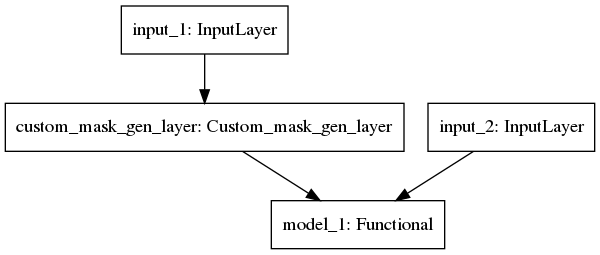

In [8]:
model1_input_layer = layers.Input(shape=(4,))
model1_layer_1 = Custom_mask_gen_layer(8)(model1_input_layer)
model1_layer_2 = Custom_mask_consume_layer(4)(model1_layer_1)
dummy_model1 = tf.keras.models.Model(model1_input_layer,model1_layer_2)


model2_input_layer1 = layers.Input(shape=(4,))
model2_input_layer2 = layers.Input(shape=(8,))
model2_layer_1 = Custom_mask_gen_layer(8)(model2_input_layer2)
dummy_model2 = tf.keras.models.Model((model2_input_layer1,model2_input_layer2),model2_layer_1)


chained_model_out = dummy_model2((model2_input_layer1,model1_layer_1))

final_model = tf.keras.models.Model((model1_input_layer,model2_input_layer1),chained_model_out)
tf.keras.utils.plot_model(final_model)

#### Testing the chained model

In [9]:
test_inputs = np.array([[1,1,2,2]])
final_model((test_inputs,test_inputs))

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.9358198 , -0.20100254,  0.6814599 , -0.07018238,  1.2736756 ,
        -1.301873  , -0.35268584, -0.33935094]], dtype=float32)>